In [315]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.dates as md
from matplotlib.patches import ConnectionPatch
import matplotlib.font_manager as font_manager
import json, requests, datetime

data = json.load(open('data/eurobarometer.json'))
answer_keys = json.load(open('data/answers_keys.json'))

columns = ["country", "date", "question", "group_ky", "tend to trust", "tend not to trust", "DK"]

df_data = []

for item in data:
    if len(item["answers"]) > 0:

        country = item["answers"][0]["country"]
        question = item["question"]
        group_ky = item["group_ky"]
        for q in item["answers"]:
            answers_temp = {}
            for q_item in q:
                if "a_" in q_item:
                    answer_key = q_item.replace("a_", "")
                    answer_type = answer_keys[answer_key]
                    date = q["fieldwork_start_dt"]
                    answers_temp[answer_type] = q[q_item]
            df_data.append([country, date, question, group_ky, answers_temp["Tend to trust"], answers_temp["Tend not to trust"], answers_temp["DK"]])

df = pd.DataFrame(df_data, columns = columns)

## Removes all data points where share of DK over 20%
df = df.loc[df['DK'] < .2]

df['trust_ratio'] = df['tend to trust'] - df ['tend not to trust']
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: md.date2num(x) / 365.25)

In [205]:
# Processes the unemployment data

countries =  [["BE", "Belgium"], ["DE", "Germany"], ["PL", "Poland"], ["GR", "Greece"], ["FR", "France"], ["IT", "Italy"],["ES", "Spain"], ["AT", "Austria"], ["SE", "Sweden"], ["RO", "Romania"],["NL", "Netherlands"], ["TR", "Turkey"]]

unemployment = pd.read_csv("data/unemployment.csv")
unemployment['GEO/TIME'] = pd.to_datetime(unemployment['GEO/TIME'], yearfirst=True)
unemployment['GEO/TIME'] = unemployment['GEO/TIME'].apply(lambda x: md.date2num(x) / 365.25)

growing_unemployment = {}
unemployment_periods = {}
unemployment_period_index = {}

for country in countries:
    growing_unemployment[country[0]] = 0
    unemployment_periods[country[0]] = []
    unemployment_period_index[country[0]] = 0

for country in countries:
    for index, row in unemployment.iterrows():
        monthly_rate = row[country[0]]
        month = unemployment['GEO/TIME'][index]
        if monthly_rate > 0.04 and growing_unemployment[country[0]] == 0:
            # Unemployment growth begins
            growing_unemployment[country[0]] = 1
            unemployment_periods[country[0]].append({"start_date": month,"end_date": 2019})
        elif monthly_rate < -0.02 and growing_unemployment[country[0]] == 1:
            # Unemployment growth ends
            growing_unemployment[country[0]] = 0
            unemployment_periods[country[0]][unemployment_period_index[country[0]]]["end_date"] = month
            unemployment_period_index[country[0]] += 1

[]

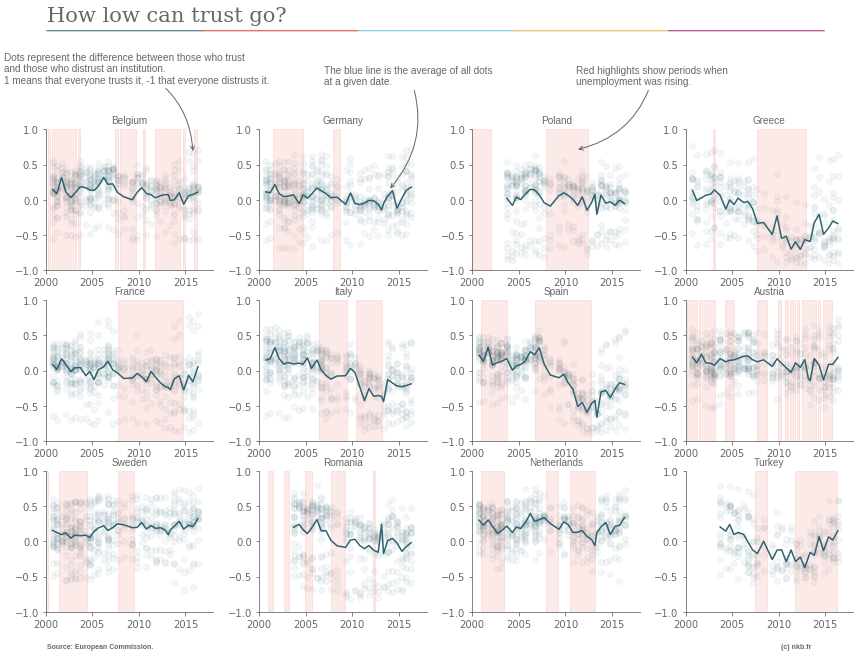

In [323]:
col_max = 4
row_max = 3
fig, ax = plt.subplots(row_max, col_max, figsize=(12, 10), facecolor="#FFFFFF")
row_num = 0
col_num = 0

# Set the default colors and fonts
colors = ['#2d616f', '#eb3721', '#67c7d3', '#dbb64b', '#a02073']
font_color = "#676767"
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
serif_font = 'Bitstream Vera Serif'
sans_font = 'Liberation Sans'     
title_font = {'fontname':serif_font
             ,'size': 21
             ,'color': font_color}
subtitle_font = {'fontname':serif_font
                ,'size': 12
                ,'color': font_color}
label_font = {'fontname':sans_font
             ,'color': font_color
             ,'size': 10}

annotate_font = {'fontname':sans_font
             ,'color': font_color
             ,'size': 7}

smaller_font = {'fontname':sans_font
                ,'color': font_color
                , 'size': 7
                , 'weight': 'bold'}

# Displays the data on the chart
for country in countries:
    if col_num >= col_max:
        col_num = 0
        row_num += 1
    axes = ax[row_num, col_num]
    col_num += 1
    
    # Same limits for everyone
    axes.set_ylim([-1,1])
    axes.set_xlim([2000,2018])
    
    ## Removes top and right axes
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    df_country = df.loc[df['country'] == country[0]]
    pivot = df_country.pivot_table(index='date')
    axes.plot(pivot.index.values, pivot['trust_ratio'], alpha=1)
    axes.scatter(df_country['date'], df_country['trust_ratio'], alpha=.05)
    axes.set_title(country[1], color=font_color).set_fontproperties(font_manager.FontProperties(family=sans_font))
    
    ## Sets axes color
    axes.spines['bottom'].set_color(font_color)
    axes.spines['left'].set_color(font_color)
    axes.tick_params(axis='x', colors=font_color)
    axes.tick_params(axis='y', colors=font_color)
    axes.yaxis.label.set_color(font_color)
    axes.xaxis.label.set_color(font_color)
    
    ## Adds highlight
    for unemployment_period in unemployment_periods[country[0]]:
        axes.axvspan(unemployment_period['start_date'], unemployment_period['end_date'], alpha=0.1, color='#eb3721')

## Adds title
plt.figtext(.05,.9,"How low can trust go?", **title_font)
# plt.figtext(.05, .83, "Subtitle.", **subtitle_font)

## Adds (c)
plt.figtext(.9, .03, '(c) nkb.fr', **smaller_font)

## Adds source
plt.figtext(.05, .03, "Source: European Commission.", **smaller_font)

## Adds annotations
plt.annotate("""Dots represent the difference between those who trust
and those who distrust an institution.
1 means that everyone trusts it, -1 that everyone distrusts it.""", 
             xy=(2.68/12, (10-2.34)/10), 
             xytext=(0.05/12, (10-0.8)/10),
             xycoords='figure fraction',
             textcoords='figure fraction',
             horizontalalignment='left', 
             verticalalignment='top',
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.3",
                            ec=font_color),
            **label_font
            )

plt.annotate("""The blue line is the average of all dots \nat a given date.""", 
             xy=(5.4/12, (10-2.9)/10), 
             xytext=(4.5/12, (10-1)/10),
             xycoords='figure fraction',
             textcoords='figure fraction',
             horizontalalignment='left', 
             verticalalignment='top',
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.3",
                            ec=font_color),
            **label_font
            )

plt.annotate("""Red highlights show periods when \nunemployment was rising.""", 
             xy=(8/12, (10-2.29)/10), 
             xytext=(8/12, (10-1)/10),
             xycoords='figure fraction',
             textcoords='figure fraction',
             horizontalalignment='left', 
             verticalalignment='top',
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.3",
                            ec=font_color),
            **label_font
            )

## Adds a horizontal line under the title
lw = 1
y_line = .887
num_colors = len(colors)
counter = 0
for color in colors:
    con = ConnectionPatch(xyA=(.05 + counter * 0.18,y_line), xyB=(.05 + (counter + 1) * 0.18,y_line), 
                          coordsA="figure fraction", coordsB="figure fraction", 
                          axesA=None, axesB=None, color=color, lw=lw)
    ax[1,1].add_artist(con)
    counter+=1


fig.tight_layout()
## Reduces size of plot to allow for subtitle text
plt.subplots_adjust(top=0.75, bottom=0.08)

plt.plot()

[]

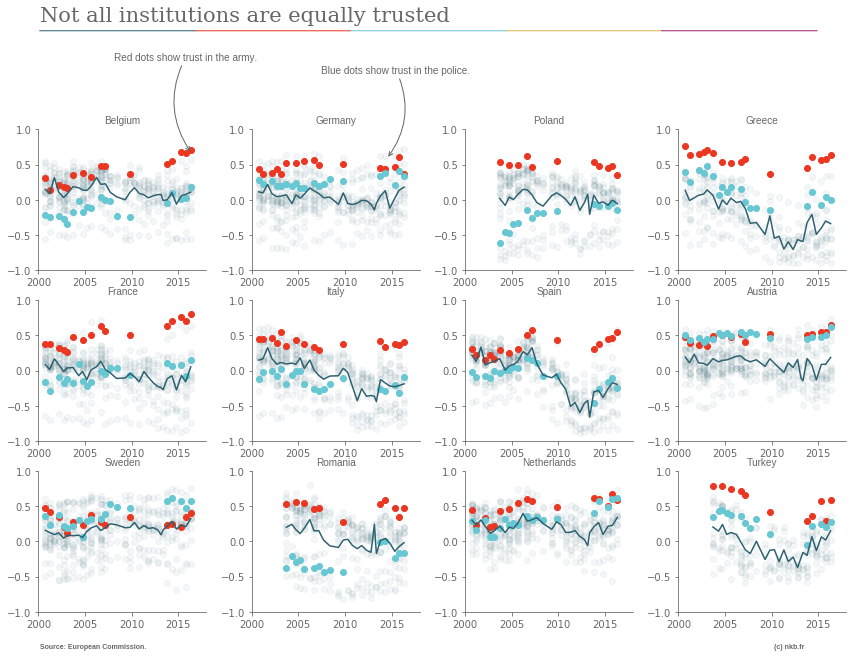

In [320]:
col_max = 4
row_max = 3
fig, ax = plt.subplots(row_max, col_max, figsize=(12, 10))
row_num = 0
col_num = 0

# Set the default colors and fonts
colors = ['#2d616f', '#eb3721', '#67c7d3', '#dbb64b', '#a02073']
font_color = "#676767"
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
serif_font = 'Bitstream Vera Serif'
sans_font = 'Liberation Sans'     
title_font = {'fontname':serif_font
             ,'size': 21
             ,'color': font_color}
subtitle_font = {'fontname':serif_font
                ,'size': 12
                ,'color': font_color}
label_font = {'fontname':sans_font
             ,'color': font_color
             ,'size': 10}

annotate_font = {'fontname':sans_font
             ,'color': font_color
             ,'size': 7}

smaller_font = {'fontname':sans_font
                ,'color': font_color
                , 'size': 7
                , 'weight': 'bold'}

# Displays the data on the chart
for country in countries:
    if col_num >= col_max:
        col_num = 0
        row_num += 1
    axes = ax[row_num, col_num]
    col_num += 1
    
    # Same limits for everyone
    axes.set_ylim([-1,1])
    axes.set_xlim([2000,2018])
    
    ## Removes top and right axes
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)

    df_country = df.loc[df['country'] == country[0]]
    # Police / Army
    df_police = df_country.loc[df_country['group_ky'] == 88]
    df_army = df_country.loc[df_country['group_ky'] == 82]
    pivot = df_country.pivot_table(index='date')
    axes.plot(pivot.index.values, pivot['trust_ratio'], alpha=1)
    axes.scatter(df_country['date'], df_country['trust_ratio'], alpha=.05)
    axes.scatter(df_army['date'], df_army['trust_ratio'], color=colors[1])
    axes.scatter(df_police['date'], df_police['trust_ratio'], color=colors[2])
    axes.set_title(country[1], color=font_color).set_fontproperties(font_manager.FontProperties(family=sans_font))
    
    ## Sets axes color
    axes.spines['bottom'].set_color(font_color)
    axes.spines['left'].set_color(font_color)
    axes.tick_params(axis='x', colors=font_color)
    axes.tick_params(axis='y', colors=font_color)
    axes.yaxis.label.set_color(font_color)
    axes.xaxis.label.set_color(font_color)
    
## Adds title
plt.figtext(.05,.9,"Not all institutions are equally trusted", **title_font)
# plt.figtext(.05, .83, "Subtitle.", **subtitle_font)

## Adds (c)
plt.figtext(.9, .03, '(c) nkb.fr', **smaller_font)

## Adds source
plt.figtext(.05, .03, "Source: European Commission.", **smaller_font)

## Adds annotations
plt.annotate("""Red dots show trust in the army.""", 
             xy=(2.68/12, (10-2.34)/10), 
             xytext=(1.6/12, (10-0.8)/10),
             xycoords='figure fraction',
             textcoords='figure fraction',
             horizontalalignment='left', 
             verticalalignment='top',
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=0.3",
                            ec=font_color),
            **label_font
            )

plt.annotate("""Blue dots show trust in the police.""", 
             xy=(5.42/12, (10-2.42)/10), 
             xytext=(4.5/12, (10-1)/10),
             xycoords='figure fraction',
             textcoords='figure fraction',
             horizontalalignment='left', 
             verticalalignment='top',
             arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.3",
                            ec=font_color),
            **label_font
            )


## Adds a horizontal line under the title
lw = 1
y_line = .887
num_colors = len(colors)
counter = 0
for color in colors:
    con = ConnectionPatch(xyA=(.05 + counter * 0.18,y_line), xyB=(.05 + (counter + 1) * 0.18,y_line), 
                          coordsA="figure fraction", coordsB="figure fraction", 
                          axesA=None, axesB=None, color=color, lw=lw)
    ax[1,1].add_artist(con)
    counter+=1


fig.tight_layout()
## Reduces size of plot to allow for subtitle text
plt.subplots_adjust(top=0.75, bottom=0.08)

plt.plot()

In [319]:
df_police_army = df.loc[(df['group_ky'] == 88) | (df['group_ky'] == 82)].sort_values("DK", ascending=False)

print(df_police_army.head())
print(df_police_army.pivot_table(index="country"))

     country         date                                         question  \
3959      DE  2002.707734  Public administration in (OUR COUNTRY) The army   
3973      PL  2004.733744  Public administration in (OUR COUNTRY) The army   
4078      NL  2003.096509  Public administration in (OUR COUNTRY) The army   
3967      DE  2013.812457  Public administration in (OUR COUNTRY) The army   
3976      PL  2007.189596  Public administration in (OUR COUNTRY) The army   

      group_ky  tend to trust  tend not to trust        DK  trust_ratio  
3959        82       0.639557           0.202139  0.158304     0.437418  
3973        82       0.671000           0.180000  0.149000     0.491000  
4078        82       0.532137           0.319238  0.148625     0.212898  
3967        82       0.650528           0.201117  0.148355     0.449410  
3976        82       0.663337           0.191808  0.144855     0.471528  
               DK         date  group_ky  tend not to trust  tend to trust  \
country  